<h3>8.1 用变分自编码器生成图像</h3>

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#在当前目录，创建不存在的目录vae_samples
sample_dir = 'vae_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# 定义一些超参数
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 0.001

# 下载MNIST训练集，这里因已下载，故download=False
dataset = torchvision.datasets.MNIST(root='data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=False)
# 数据加载
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 开始训练模型
for epoch in range(num_epochs):
    model.train()
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        model.zero_grad()
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播及优化器
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

    with torch.no_grad():
        # 保存采样图像，即潜在向量Z通过解码器生成的新图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 保存重构图像，即原图像通过解码器生成的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

D:\anaconda3\envs\pytorch_learning\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\anaconda3\envs\pytorch_learning\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/30], Step [100/469], Reconst Loss: 22185.9082, KL Div: 1257.3223
Epoch[1/30], Step [200/469], Reconst Loss: 17119.0781, KL Div: 2008.2366
Epoch[1/30], Step [300/469], Reconst Loss: 15859.4131, KL Div: 2408.3328
Epoch[1/30], Step [400/469], Reconst Loss: 14146.8027, KL Div: 2583.8823
Epoch[2/30], Step [100/469], Reconst Loss: 13345.4609, KL Div: 2834.4761
Epoch[2/30], Step [200/469], Reconst Loss: 12324.5479, KL Div: 2888.2065
Epoch[2/30], Step [300/469], Reconst Loss: 12720.0088, KL Div: 2833.7310
Epoch[2/30], Step [400/469], Reconst Loss: 12197.3184, KL Div: 3028.5757
Epoch[3/30], Step [100/469], Reconst Loss: 11965.6602, KL Div: 3065.0420
Epoch[3/30], Step [200/469], Reconst Loss: 11550.5312, KL Div: 3070.5789
Epoch[3/30], Step [300/469], Reconst Loss: 11250.1777, KL Div: 3082.1025
Epoch[3/30], Step [400/469], Reconst Loss: 11595.3506, KL Div: 3024.1929
Epoch[4/30], Step [100/469], Reconst Loss: 11203.7930, KL Div: 3108.1685
Epoch[4/30], Step [200/469], Reconst Loss: 10997.71

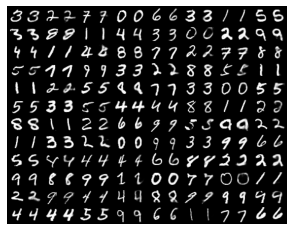

In [4]:
import matplotlib.pyplot as plt
import cv2
reconsPath = './vae_samples/reconst-30.png'
Image = cv2.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

<h3>8.3 用GAN生成图像</h3>

In [5]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


# 设备配置
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义一些超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'gan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
trans = transforms.Compose([
                transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='data',
                                   train=True,
                                   transform=trans,
                                   download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# 构建生成器，这个相当于VAE中的解码器
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)

In [6]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      训练判别器                                      #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake

        # 对生成器、判别器的梯度清零
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        训练生成器                                    #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        # 判别器生成的图片越来越像真图片，故损失函数中
        # 的标签改为真图片的标签，即希望生成的假图片，
        # 越来越靠近真图片
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)


        g_loss = criterion(outputs, real_labels)

        # 对生成器、判别器的梯度清零
        #进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # 保存真图片
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/200], Step [200/600], d_loss: 0.0433, g_loss: 3.8332, D(x): 1.00, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.0489, g_loss: 5.3156, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [600/600], d_loss: 0.0926, g_loss: 4.2155, D(x): 0.96, D(G(z)): 0.05
Epoch [1/200], Step [200/600], d_loss: 0.0982, g_loss: 4.7915, D(x): 0.98, D(G(z)): 0.07
Epoch [1/200], Step [400/600], d_loss: 0.0785, g_loss: 4.3791, D(x): 0.97, D(G(z)): 0.04
Epoch [1/200], Step [600/600], d_loss: 0.6262, g_loss: 3.8281, D(x): 0.84, D(G(z)): 0.23
Epoch [2/200], Step [200/600], d_loss: 0.2578, g_loss: 2.7934, D(x): 0.90, D(G(z)): 0.12
Epoch [2/200], Step [400/600], d_loss: 0.2785, g_loss: 3.8744, D(x): 0.90, D(G(z)): 0.11
Epoch [2/200], Step [600/600], d_loss: 0.6793, g_loss: 4.7985, D(x): 0.77, D(G(z)): 0.08
Epoch [3/200], Step [200/600], d_loss: 0.4103, g_loss: 2.6407, D(x): 0.85, D(G(z)): 0.14
Epoch [3/200], Step [400/600], d_loss: 0.3028, g_loss: 3.3583, D(x): 0.88, D(G(z)): 0.09
Epoch [3/200], Step [

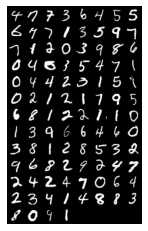

In [7]:
reconsPath = './gan_samples/real_images.png'
Image = cv2.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

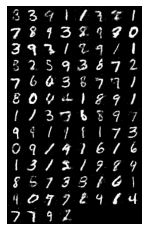

In [8]:
reconsPath = './gan_samples/fake_images-200.png'
Image = cv2.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()